## 0 環境構築

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
np.set_printoptions(precision=8)
np.random.seed(123)

In [2]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 14.0MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=2b3d399a13cf1d1c0f729066a4a1fc1d70655cde554126d7feaf9294a94ff5b8
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [3]:
import japanize_matplotlib
import matplotlib as mpl
font = mpl.rcParams['font.family']
sns.set(context='notebook', style='whitegrid', font=font)

## 1 ダウンロード

### 1.1 rakuten-1000-2020_2021

In [4]:
FILE_ID = "1-8DA4NG3v0GypES0Q6SJ-qW3k2VU7BjZ"
FILE_NAME = "rakuten-1000-2020-2021.tsv.zip"
# !curl -sc ./cookie "https://drive.google.com/uc?export=download&id={FILE_ID}"
# CODE = !awk '/_warning_/ {print $NF}' ./cookie
# !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={CODE[0]}&id={FILE_ID}" -o {FILE_NAME}

!curl -L "https://docs.google.com/uc?export=download&id={FILE_ID}" > {FILE_NAME}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    368      0 --:--:--  0:00:01 --:--:--   368
100 1552k  100 1552k    0     0  1103k      0  0:00:01  0:00:01 --:--:--  220M


In [5]:
!ls -al

total 1572
drwxr-xr-x 1 root root    4096 Jul  8 08:49 .
drwxr-xr-x 1 root root    4096 Jul  8 08:32 ..
drwxr-xr-x 4 root root    4096 Jul  1 13:41 .config
-rw-r--r-- 1 root root 1589449 Jul  8 08:49 rakuten-1000-2020-2021.tsv.zip
drwxr-xr-x 1 root root    4096 Jul  1 13:42 sample_data


In [6]:
!unzip rakuten-1000-2020-2021.tsv.zip
!wc -l *.tsv

Archive:  rakuten-1000-2020-2021.tsv.zip
  inflating: rakuten-1000-2020-2021.tsv  
10001 rakuten-1000-2020-2021.tsv


In [7]:
!head -n +4 rakuten-1000-2020-2021.tsv

カテゴリー	エリア	施設番号	施設名	コメント	総合	サービス	立地	部屋	設備・アメニティ	風呂	食事	旅行の目的	同伴者	宿泊年月	投稿者	年代	性別	投稿回数
A_レジャー	01_登別	28637	登別温泉　登別万世閣	8月10日に泊まりました。子供に必要なものが無料で借りられたり便利でした。また、エアコンの結露のため水漏れしていたところ、速やかに部屋をかえてもらえました。大浴場の中は子連れで入浴しやすいように物品が揃っていました。出入り口に階段があるので、子供が抱っこだと少し大変です。	5	5	5	5	5	3	4	レジャー	家族	2020-08-10	投稿者	na	na	na
A_レジャー	01_登別	17810	洞爺サンパレス　リゾート＆スパ	お風呂、食事とも大変満足できました。心が癒されました。	5	4	4	4	4	5	5	レジャー	家族	2021-03-14	shocomama	60代	女性	na
A_レジャー	01_登別	28637	登別温泉　登別万世閣	夕食がバイキングなので落ち着いてゆったりと食事が出来ない！ さらにガキどもが騒いでいて五月蝿かった！	5	5	5	5	5	5	4	レジャー	一人	2020-09-19	投稿者	na	na	na


In [8]:
df_all = pd.read_csv("rakuten-1000-2020-2021.tsv", sep='\t', quoting=3, escapechar='\\')
df_all['宿泊年月'] = pd.to_datetime(df_all['宿泊年月'], format='%Y-%m-%d')
df_all['index'] = df_all.index
df_all.set_index('宿泊年月', inplace=True)
df_all = df_all.tz_localize('Asia/Tokyo')
print(df_all.shape)
df_all.head()

(10000, 19)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,投稿者,年代,性別,投稿回数,index
宿泊年月,,,,,,,,,,,,,,,,,,,
2020-08-10 00:00:00+09:00,A_レジャー,01_登別,28637,登別温泉 登別万世閣,8月10日に泊まりました。子供に必要なものが無料で借りられたり便利でした。また、エアコンの結...,5,5,5,5,5,3,4,レジャー,家族,投稿者,na,na,na,0
2021-03-14 00:00:00+09:00,A_レジャー,01_登別,17810,洞爺サンパレス リゾート＆スパ,お風呂、食事とも大変満足できました。心が癒されました。,5,4,4,4,4,5,5,レジャー,家族,shocomama,60代,女性,na,1
2020-09-19 00:00:00+09:00,A_レジャー,01_登別,28637,登別温泉 登別万世閣,夕食がバイキングなので落ち着いてゆったりと食事が出来ない！ さらにガキどもが騒いでいて五月蝿...,5,5,5,5,5,5,4,レジャー,一人,投稿者,na,na,na,2
2020-06-14 00:00:00+09:00,A_レジャー,01_登別,12568,登別温泉 ホテル まほろば,コロナの自粛期間ではありますが感染対策も整っていました宿泊者としては他に客足も少なくゆったり...,4,4,5,4,3,5,4,レジャー,家族,投稿者,na,na,na,3
2021-03-26 00:00:00+09:00,A_レジャー,01_登別,5500,登別 石水亭,夕食はジンギスカンやアイヌ料理もあり、北海道感たっぷりです。朝食に実演が３種類もあり、とても...,5,4,4,3,3,5,5,レジャー,家族,プログレス１９６８,50代,男性,na,4


## 2 クチコミ "rakuten-1000-2020-2021" のテキスト分析

### 2.1 MeCab + neologd インストール

In [9]:
!apt install mecab libmecab-dev file
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n
!cp /etc/mecabrc /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/mecabrc
!pip install fugashi ipadic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmagic-mgc libmagic1 libmecab2 mecab-jumandic mecab-jumandic-utf8
  mecab-utils
The following NEW packages will be installed:
  file libmagic-mgc libmagic1 libmecab-dev libmecab2 mecab mecab-jumandic
  mecab-jumandic-utf8 mecab-utils
0 upgraded, 9 newly installed, 0 to remove and 39 not upgraded.
Need to get 17.1 MB of archives.
After this operation, 227 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 file amd64 1:5.32-2ubuntu0.4 [22.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmecab2 amd64 0.996-5 [257 kB]
Get:5 http://archive.ubuntu.co

In [10]:
import os, subprocess, ipadic
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True).communicate()[0]).decode('utf-8').strip()
ipadic.DICDIR = path_neologd
ipadic.MECAB_ARGS = '-r "{}" -d "{}"'.format(os.path.join(ipadic.DICDIR, 'mecabrc'), ipadic.DICDIR)
print(ipadic.MECAB_ARGS)

-r "/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/mecabrc" -d "/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"


In [11]:
from fugashi import GenericTagger
import ipadic

# m = GenericTagger(ipadic.MECAB_ARGS + " " + "-Owakati")
# m = GenericTagger(ipadic.MECAB_ARGS + " " + '--node-format="%pS%f[6]\\s" --eos-format="\\n" --unk-format="%m"')
m = GenericTagger(ipadic.MECAB_ARGS)

text = "私はフック船長が好きです。親がコロナになる。"

for word in m.parseToNodeList(text):
    print(word.surface, word.feature)

私 ('名詞', '代名詞', '一般', '*', '*', '*', '私', 'ワタシ', 'ワタシ')
は ('助詞', '係助詞', '*', '*', '*', '*', 'は', 'ハ', 'ワ')
フック船長 ('名詞', '固有名詞', '人名', '一般', '*', '*', 'フック船長', 'フックセンチョウ', 'フックセンチョー')
が ('助詞', '格助詞', '一般', '*', '*', '*', 'が', 'ガ', 'ガ')
好き ('名詞', '形容動詞語幹', '*', '*', '*', '*', '好き', 'スキ', 'スキ')
です ('助動詞', '*', '*', '*', '特殊・デス', '基本形', 'です', 'デス', 'デス')
。 ('記号', '句点', '*', '*', '*', '*', '。', '。', '。')
親 ('名詞', '一般', '*', '*', '*', '*', '親', 'オヤ', 'オヤ')
が ('助詞', '格助詞', '一般', '*', '*', '*', 'が', 'ガ', 'ガ')
コロナ ('名詞', '一般', '*', '*', '*', '*', 'コロナ', 'コロナ', 'コロナ')
に ('助詞', '格助詞', '一般', '*', '*', '*', 'に', 'ニ', 'ニ')
なる ('動詞', '自立', '*', '*', '五段・ラ行', '基本形', 'なる', 'ナル', 'ナル')
。 ('記号', '句点', '*', '*', '*', '*', '。', '。', '。')


In [12]:
m = GenericTagger(ipadic.MECAB_ARGS)

# def mecab_tokenizer(text):
#     return m.parse(text)

def mecab_tokenizer(text):
    ret = []
    for word in m.parseToNodeList(text):
        # 品詞を選択する
        if word.feature[0] not in ['名詞','形容詞','形容動詞','未知語']:
            continue
        # # 不要語を除去する
        # if word.feature[0] == '名詞' and word.feature[1] == '非自立':  # 'よう'
        #     continue
        # if word.feature[0] == '動詞' and word.feature[1] == '非自立':  # 'いる'
        #     continue
        # if word.feature[0] == '動詞' and word.feature[1] == '接尾':    # 'られる'
        #     continue
        # if word.feature[0] == '動詞' and word.feature[1] == '自立' and word.feature[6] in ['ある','する']:
        #     continue
        ret.append(word.feature[6])
    return ' '.join(ret)

In [13]:
" ".join(df_all['コメント'][0:100].map(mecab_tokenizer))

'8月10日 子供 必要 もの 無料 便利 エアコン 結露 ため 水漏れ ところ 速やか 部屋 大浴場 中 子連れ 入浴 やすい よう 物品 出入り口 階段 子供 抱っこ 大変 風呂 食事 大変 満足 心 夕食 バイキング 食事 ガキ ども 五月蝿い コロナ 自粛 期間 感染対策 宿泊 者 他 客足 少ない 温泉 食事 以前 イマイチ 感じ ホテル 関係 者 方 大変 維持 夕食 ジンギスカン アイヌ料理 北海道 感 たっぷり 朝食 実演 ３ 種類 良い 焼き立て クロワッサン 美味しい 難点 Wi-Fi 電波 弱い こと 妊娠 * ヶ月 普通 部屋 大部屋 用意 部屋 2つ 分 部屋 大きい さ 子供達 大橋 * 心遣い よい ご飯 スイーツ! 他 ホテル 美味しい 露天風呂 最高 全体的 満足 プール 日帰り 人 時間 調整 宿泊 人 混雑 コロナ 対策 バイキング 形式 順路 混雑 密 の 残念 順路 スムーズ 配膳 の 食事 美味しい 夕食 酷い 最後 の 大変 程 塩気 食材 味 宿 方 客 物 自分 美味しい 完 食 試食 の 宿泊客 日本人 今 状況 料理 人 どれ 品数 美味しい 物 毎年 楽しみ 温泉旅行 別 所 * キャンペーン 安い 以外 部屋 ホコリ ぽい 感じ 料理 一部 冷たい 終焉 * 呼応 情報 質問 島 今一つ 真剣 気 客 * ニーズ 相応しい 提案 10月 ３ １ 日 宿泊 ロングラン 花火 最終日 部屋 湖畔 側 景色 食事 満足 風呂 よい 料理 温泉 最高 部屋 WiFi の 残念 改善 欲しい 点 今 温泉宿 一番 良い 眺め よい スタッフ さん 対応 素晴らしい ご飯 美味しい お部屋 テレビ ない の 暇 それ それ リラックス の 絶対 宿 利用 清潔感 立地 良い 温泉 何 回 よう ホテル 前回 宿泊 際 良い コロナ禍 どこ 旅行 中 久しぶり 今回 楽しみ 予約 食事 風呂 前回 宿泊 時 同様 大変 満足 お部屋 壁 薄い の お隣 声 大きい の 夜中 3時 男性 笑い声 話し声 うるさい 中央 棟 お部屋 宿泊 トイレ 玄関 仕切り 必要 大変 不便 其の様 間取り 宿泊施設 今回 びっくり コロナ 対策 食事 会場 入り口 消毒 夕食 入場 際 機械 不具合 消毒 私 前後 数 名 手 消毒 困惑

In [14]:
df_all['mecab'] = df_all['コメント'].map(mecab_tokenizer)
df_all['length'] = df_all['mecab'].map(lambda x: x.split()).map(len)
print(df_all.shape)
df_all.head()

(10000, 21)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,投稿者,年代,性別,投稿回数,index,mecab,length
宿泊年月,,,,,,,,,,,,,,,,,,,,,
2020-08-10 00:00:00+09:00,A_レジャー,01_登別,28637,登別温泉 登別万世閣,8月10日に泊まりました。子供に必要なものが無料で借りられたり便利でした。また、エアコンの結...,5,5,5,5,5,3,4,レジャー,家族,投稿者,na,na,na,0,8月10日 子供 必要 もの 無料 便利 エアコン 結露 ため 水漏れ ところ 速やか 部屋...,25
2021-03-14 00:00:00+09:00,A_レジャー,01_登別,17810,洞爺サンパレス リゾート＆スパ,お風呂、食事とも大変満足できました。心が癒されました。,5,4,4,4,4,5,5,レジャー,家族,shocomama,60代,女性,na,1,風呂 食事 大変 満足 心,5
2020-09-19 00:00:00+09:00,A_レジャー,01_登別,28637,登別温泉 登別万世閣,夕食がバイキングなので落ち着いてゆったりと食事が出来ない！ さらにガキどもが騒いでいて五月蝿...,5,5,5,5,5,5,4,レジャー,一人,投稿者,na,na,na,2,夕食 バイキング 食事 ガキ ども 五月蝿い,6
2020-06-14 00:00:00+09:00,A_レジャー,01_登別,12568,登別温泉 ホテル まほろば,コロナの自粛期間ではありますが感染対策も整っていました宿泊者としては他に客足も少なくゆったり...,4,4,5,4,3,5,4,レジャー,家族,投稿者,na,na,na,3,コロナ 自粛 期間 感染対策 宿泊 者 他 客足 少ない 温泉 食事 以前 イマイチ 感じ ...,20
2021-03-26 00:00:00+09:00,A_レジャー,01_登別,5500,登別 石水亭,夕食はジンギスカンやアイヌ料理もあり、北海道感たっぷりです。朝食に実演が３種類もあり、とても...,5,4,4,3,3,5,5,レジャー,家族,プログレス１９６８,50代,男性,na,4,夕食 ジンギスカン アイヌ料理 北海道 感 たっぷり 朝食 実演 ３ 種類 良い 焼き立て ...,19


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(max_df=1.0, min_df=1, max_features=500)
bag = count.fit_transform(df_all['mecab'].values)
feature_names = count.get_feature_names()
feature_names[0:10]

['10分', '1つ', '1人', '1番', '24時間', '2つ', '2人', '2回目', '4人', 'cospa']

In [16]:
tf = bag.toarray().sum(axis=0)
for i in tf.argsort()[:-10:-1]:
    print(tf[i], "\t", count.get_feature_names()[i])

4866 	 良い
4719 	 部屋
3704 	 利用
2745 	 こと
2700 	 宿泊
2544 	 風呂
2502 	 食事
2500 	 ホテル
2109 	 ない


In [17]:
df_count = pd.DataFrame(bag.toarray())
df_count.columns = feature_names
print(df_count.shape)
df_count.head()

(10000, 500)


,10分,1つ,1人,1番,24時間,2つ,2人,2回目,4人,cospa,fi,go,to,wi,あと,ありがたい,いい,いつ,うるさい,うれしい,おいしい,おかげ,おかず,おしゃれ,おすすめ,おもてなし,お世話,お世話になりました,お勧め,お安い,お客様,お気に入り,お湯,お祝い,お肉,お茶,お部屋,お酒,お願い,きれい,...,追加,送迎,通り,通常,連れ,連絡,遅い,道後温泉,遠い,選択,邪魔,部分,部屋,配慮,野菜,金額,長い,階段,離れ,難しい,雰囲気,電子レンジ,電話,露天,露天風呂,静か,非常,風呂,食事,食事処,食材,飲み放題,飲み物,飲食店,館内,香り,駐車,駐車場,高い,髪の毛
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
df_count.sum(axis=0).describe()

count     500.000000
mean      284.662000
std       500.514088
min        62.000000
25%        83.000000
50%       126.000000
75%       257.000000
max      4866.000000
dtype: float64

In [19]:
# TF >= 500 に絞る
df_count = df_count.loc[:, (df_count.sum(axis=0) >= 500)]
print(df_count.shape)
df_count.sum(axis=0).describe()

(10000, 53)


count      53.000000
mean     1365.396226
std       989.379902
min       502.000000
25%       719.000000
50%       970.000000
75%      1634.000000
max      4866.000000
dtype: float64

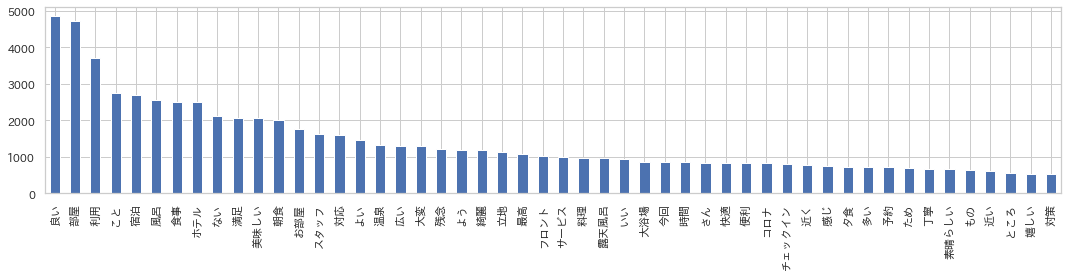

In [20]:
df_count.sum(axis=0).sort_values(ascending=False)[0:50].plot.bar(figsize=(15, 4), grid=True)
plt.tight_layout()

### 2.2 対応分析

#### 2.2.1 対応分析 by MCA

In [21]:
df_all[['index', 'カテゴリー', 'エリア']].head()

,index,カテゴリー,エリア
宿泊年月,,,
2020-08-10 00:00:00+09:00,0,A_レジャー,01_登別
2021-03-14 00:00:00+09:00,1,A_レジャー,01_登別
2020-09-19 00:00:00+09:00,2,A_レジャー,01_登別
2020-06-14 00:00:00+09:00,3,A_レジャー,01_登別
2021-03-26 00:00:00+09:00,4,A_レジャー,01_登別


In [22]:
df_merge = pd.merge(df_all[['index', 'カテゴリー', 'エリア']], df_count, left_on='index', how='inner', right_index=True)
print(df_merge.shape)
df_merge.head()

(10000, 56)


,index,カテゴリー,エリア,いい,お部屋,こと,さん,ため,ところ,ない,もの,よい,よう,アメニティ,コロナ,コンビニ,サービス,スタッフ,チェックイン,フロント,ホテル,丁寧,予約,今回,便利,利用,夕食,多い,大変,大浴場,嬉しい,安心,宿泊,対応,対策,広い,快適,感じ,料理,時間,最高,朝食,残念,温泉,満足,立地,素晴らしい,綺麗,美味しい,良い,近い,近く,部屋,露天風呂,風呂,食事
宿泊年月,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-10 00:00:00+09:00,0,A_レジャー,01_登別,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2021-03-14 00:00:00+09:00,1,A_レジャー,01_登別,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
2020-09-19 00:00:00+09:00,2,A_レジャー,01_登別,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2020-06-14 00:00:00+09:00,3,A_レジャー,01_登別,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2021-03-26 00:00:00+09:00,4,A_レジャー,01_登別,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [23]:
df_period2 = df_merge.groupby(["エリア"]).sum()
df_period2.drop('index', axis=1, inplace=True)
print(df_period2.shape)
df_period2.head()

(10, 53)


,いい,お部屋,こと,さん,ため,ところ,ない,もの,よい,よう,アメニティ,コロナ,コンビニ,サービス,スタッフ,チェックイン,フロント,ホテル,丁寧,予約,今回,便利,利用,夕食,多い,大変,大浴場,嬉しい,安心,宿泊,対応,対策,広い,快適,感じ,料理,時間,最高,朝食,残念,温泉,満足,立地,素晴らしい,綺麗,美味しい,良い,近い,近く,部屋,露天風呂,風呂,食事
エリア,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01_登別,108,206,302,99,65,66,226,99,130,158,28,137,14,118,177,80,62,220,57,85,100,24,301,142,105,161,102,69,56,337,156,91,88,44,70,181,123,167,141,191,231,268,38,117,98,280,525,21,42,512,163,399,463
02_草津,142,194,305,137,62,73,253,87,160,111,27,95,19,134,165,79,62,218,83,84,100,40,360,117,107,164,69,51,48,301,189,78,139,39,95,174,101,176,150,136,276,283,155,90,110,304,611,55,76,459,131,481,436
03_箱根,112,289,406,136,95,86,306,94,195,203,44,108,22,174,251,112,86,186,114,112,103,29,346,172,108,150,123,76,66,294,175,83,155,53,118,191,134,118,164,194,254,303,45,97,127,362,629,42,49,590,279,405,541
04_道後,71,162,228,60,55,36,163,61,139,98,50,74,38,101,134,65,111,239,59,46,84,94,369,95,77,108,84,69,51,277,144,36,119,89,80,101,60,85,240,117,145,172,133,46,97,205,454,59,71,428,85,230,223
05_湯布院,122,292,435,171,62,67,243,78,209,159,35,73,24,116,241,60,47,31,86,86,84,20,292,134,96,203,48,61,58,323,161,41,137,31,79,268,149,237,128,122,280,314,72,130,102,439,604,26,54,522,268,403,497


In [24]:
!pip install mca

  Created wheel for mca: filename=mca-1.0.3-py2.py3-none-any.whl size=6025 sha256=1881d1402869feea1131e084d013d6112426aec1372bf7185af09ffc24d0628f
  Stored in directory: /root/.cache/pip/wheels/01/fb/ff/19d72d65c8bb01d4af40c9c2ca20fd267d1969b3b5f8dd60d6
Successfully built mca


In [25]:
import mca
ncols = df_period2.shape[1]
mca_ben = mca.MCA(df_period2, ncols=ncols, benzecri=False)
mca_ben.fs_r(N=2)

array([[-0.29395596,  0.11386648],
       [-0.23735797,  0.04137219],
       [-0.29469731,  0.01938998],
       [ 0.02318495,  0.02602948],
       [-0.41652553, -0.14399044],
       [ 0.33561061, -0.00898572],
       [ 0.37750796,  0.02365126],
       [ 0.3806779 , -0.03958704],
       [ 0.36970555, -0.00245256],
       [ 0.3537698 , -0.0285324 ]])

In [26]:
result_row = pd.DataFrame(mca_ben.fs_r(N=2))
result_row.index = list(df_period2.index)
print(result_row.shape)
result_row

(10, 2)


,0,1
01_登別,-0.293956,0.113866
02_草津,-0.237358,0.041372
03_箱根,-0.294697,0.019390
04_道後,0.023185,0.026029
05_湯布院,-0.416526,-0.143990
06_札幌,0.335611,-0.008986
07_名古屋,0.377508,0.023651
08_東京,0.380678,-0.039587
09_大阪,0.369706,-0.002453
10_福岡,0.353770,-0.028532


In [27]:
result_col = pd.DataFrame(mca_ben.fs_c(N=2))
result_col.index = list(df_period2.columns)
print(result_col.shape)
result_col.head()

(53, 2)


,0,1
いい,-0.033634,0.002312
お部屋,-0.146636,-0.076383
こと,-0.077834,-0.078447
さん,-0.309692,-0.112972
ため,0.173348,-0.012591


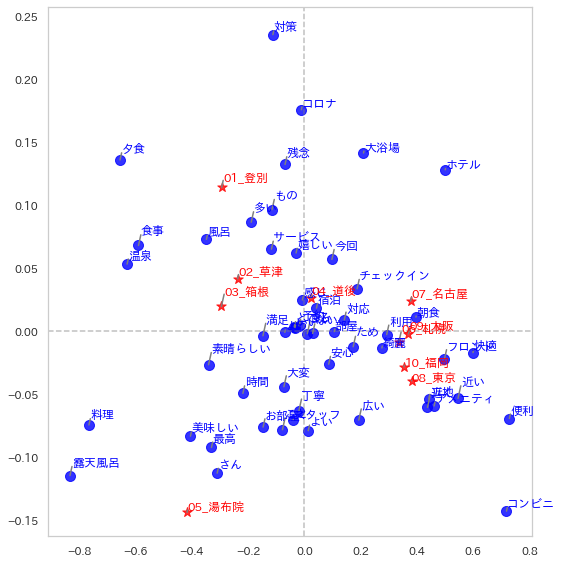

In [28]:
import random

plt.figure(figsize=(8,8))

# 列方向のプロット (単語)
plt.scatter(result_col[0], result_col[1], s=100, marker="o", c="blue", alpha=0.8)
for i in range(result_col.shape[0]):
    r = random.random() * 0.01
    plt.text(result_col.iloc[i, 0]+r, result_col.iloc[i, 1]+r, result_col.index[i], c="blue")
    plt.plot([result_col.iloc[i, 0]+r, result_col.iloc[i, 0]], [result_col.iloc[i, 1]+r, result_col.iloc[i, 1]], c="gray")

# 行方向のプロット (外部変数)
plt.scatter(result_row[0], result_row[1], s=100, marker="*", c="red", alpha=0.8)
for i in range(result_row.shape[0]):
    r = random.random() * 0.01
    plt.text(result_row.iloc[i, 0]+r, result_row.iloc[i, 1]+r, result_row.index[i], c="red")
    plt.plot([result_row.iloc[i, 0]+r, result_row.iloc[i, 0]], [result_row.iloc[i, 1]+r, result_row.iloc[i, 1]], c="gray")

plt.axhline(0, c="gray", ls='--', alpha=0.5)
plt.axvline(0, c="gray", ls='--', alpha=0.5)
plt.grid(False)
plt.tight_layout()

#### 2.2.2 対応分析 by SVD

In [29]:
print(df_period2.shape)
df_period2.head()

(10, 53)


,いい,お部屋,こと,さん,ため,ところ,ない,もの,よい,よう,アメニティ,コロナ,コンビニ,サービス,スタッフ,チェックイン,フロント,ホテル,丁寧,予約,今回,便利,利用,夕食,多い,大変,大浴場,嬉しい,安心,宿泊,対応,対策,広い,快適,感じ,料理,時間,最高,朝食,残念,温泉,満足,立地,素晴らしい,綺麗,美味しい,良い,近い,近く,部屋,露天風呂,風呂,食事
エリア,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01_登別,108,206,302,99,65,66,226,99,130,158,28,137,14,118,177,80,62,220,57,85,100,24,301,142,105,161,102,69,56,337,156,91,88,44,70,181,123,167,141,191,231,268,38,117,98,280,525,21,42,512,163,399,463
02_草津,142,194,305,137,62,73,253,87,160,111,27,95,19,134,165,79,62,218,83,84,100,40,360,117,107,164,69,51,48,301,189,78,139,39,95,174,101,176,150,136,276,283,155,90,110,304,611,55,76,459,131,481,436
03_箱根,112,289,406,136,95,86,306,94,195,203,44,108,22,174,251,112,86,186,114,112,103,29,346,172,108,150,123,76,66,294,175,83,155,53,118,191,134,118,164,194,254,303,45,97,127,362,629,42,49,590,279,405,541
04_道後,71,162,228,60,55,36,163,61,139,98,50,74,38,101,134,65,111,239,59,46,84,94,369,95,77,108,84,69,51,277,144,36,119,89,80,101,60,85,240,117,145,172,133,46,97,205,454,59,71,428,85,230,223
05_湯布院,122,292,435,171,62,67,243,78,209,159,35,73,24,116,241,60,47,31,86,86,84,20,292,134,96,203,48,61,58,323,161,41,137,31,79,268,149,237,128,122,280,314,72,130,102,439,604,26,54,522,268,403,497


In [30]:
# 観測度数の行合計
row_sum = df_period2.sum(axis=1)
print(row_sum.shape)
row_sum

(10,)


エリア
01_登別     8243
02_草津     8591
03_箱根     9706
04_道後     6717
05_湯布院    9020
06_札幌     6148
07_名古屋    5591
08_東京     6068
09_大阪     5958
10_福岡     6324
dtype: int64

In [31]:
# 観測度数の列合計
col_sum = df_period2.sum(axis=0)
print(col_sum.shape)
col_sum.head()

(53,)


いい      933
お部屋    1766
こと     2745
さん      843
ため      682
dtype: int64

In [32]:
n = row_sum.sum()
n

72366

In [33]:
# 期待度数
expected = np.outer(row_sum.values, col_sum.values) / row_sum.sum()
df_expected = pd.DataFrame(expected)
df_expected.index = df_period2.index
df_expected.columns = df_period2.columns

# χ二乗距離
df_chisq = (df_period2 - df_expected) ** 2 / df_expected
print(df_chisq.shape)
df_chisq.head()

(10, 53)


,いい,お部屋,こと,さん,ため,ところ,ない,もの,よい,よう,アメニティ,コロナ,コンビニ,サービス,スタッフ,チェックイン,フロント,ホテル,丁寧,予約,今回,便利,利用,夕食,多い,大変,大浴場,嬉しい,安心,宿泊,対応,対策,広い,快適,感じ,料理,時間,最高,朝食,残念,温泉,満足,立地,素晴らしい,綺麗,美味しい,良い,近い,近く,部屋,露天風呂,風呂,食事
エリア,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01_登別,0.027989,0.116457,0.364450,0.092254,2.071193,0.132855,0.842917,8.414704,7.487024,3.477926,14.892119,20.348506,33.037579,0.242743,0.447285,1.384575,26.334753,14.730800,5.143945,0.187365,0.015634,52.955132,34.651012,44.104305,6.515904,1.368255,0.106465,1.304351,0.101413,2.820213,3.630274,17.826430,24.449254,27.377775,2.248942,44.996688,7.505803,15.819468,34.425650,19.686127,42.025211,4.501104,64.245604,23.427285,10.401812,8.813600,1.545888,34.037241,24.436700,1.212319,26.321130,41.166081,111.179269
02_草津,8.809994,1.168590,1.337260,13.622097,4.442012,0.795097,0.027585,1.253408,0.855911,6.761501,17.827902,0.056590,28.079909,2.308370,4.330045,2.723021,29.979005,20.916656,0.102555,0.003270,0.083223,35.069932,14.454317,11.730680,5.487892,0.787147,11.182945,2.177177,2.733002,1.190338,0.000654,4.650123,1.545401,36.371341,0.687238,30.070853,0.006447,17.915938,33.559758,0.511025,88.837023,5.765692,3.122831,1.769604,6.922379,14.514414,1.922823,4.289773,2.859996,18.288551,2.545569,106.075387,65.022274
03_箱根,1.379228,11.476329,3.887148,4.651723,0.136040,1.840846,1.891826,0.533449,0.001393,11.306736,8.083972,0.035699,30.998258,12.794459,4.626332,0.194133,19.931355,66.485750,6.082551,2.852243,1.517812,61.252497,45.771355,59.211622,1.386941,3.029446,0.387729,0.379284,0.114392,12.819179,7.083442,2.807736,2.178031,30.971139,3.825272,28.507325,3.821726,4.933222,42.117917,5.745752,32.329024,2.394717,75.287900,0.839192,6.661566,26.681426,0.856733,19.573990,29.253257,2.911833,175.307736,11.925343,125.748373
04_道後,2.810458,0.022485,2.816933,4.255203,1.089076,4.625316,5.481401,0.007376,0.144582,1.525284,0.248741,0.058619,1.711934,0.902828,2.058082,1.175514,2.383398,0.208181,0.213033,6.105772,0.154422,3.598840,1.846412,11.968858,1.578120,1.133360,0.154422,8.154548,0.240411,2.778161,0.110663,2.913929,0.025610,1.734721,2.033164,1.335322,4.293511,2.292514,14.761852,0.137690,3.832577,2.055492,7.367426,3.761369,1.639149,1.008625,0.012110,0.084759,0.017424,0.229069,0.189298,0.159324,0.367254
05_湯布院,0.280066,23.471135,25.197990,41.361880,6.226957,0.061030,1.502610,0.112475,4.420662,0.660858,12.149016,8.346883,24.202667,0.443496,6.842663,15.897680,51.913719,252.694404,0.041349,0.085007,5.359628,67.681097,62.363234,21.978103,0.454313,11.154416,33.386702,0.351858,0.552259,0.544696,7.189888,8.378914,3.904301,51.197779,1.736639,178.958790,18.236444,78.132204,60.761175,5.855944,79.164890,12.329267,33.930047,27.885522,14.469090,129.574540,0.010458,33.144060,18.957395,7.449711,183.900410,23.272881,109.911362


In [34]:
#  残差
df_residuals = (df_period2 - df_expected) / np.sqrt(df_expected)

# 標準化残差
df_residuals = df_residuals / np.sqrt(n)

print(df_residuals.shape)
df_residuals.head()

(10, 53)


,いい,お部屋,こと,さん,ため,ところ,ない,もの,よい,よう,アメニティ,コロナ,コンビニ,サービス,スタッフ,チェックイン,フロント,ホテル,丁寧,予約,今回,便利,利用,夕食,多い,大変,大浴場,嬉しい,安心,宿泊,対応,対策,広い,快適,感じ,料理,時間,最高,朝食,残念,温泉,満足,立地,素晴らしい,綺麗,美味しい,良い,近い,近く,部屋,露天風呂,風呂,食事
エリア,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01_登別,0.000622,0.001269,-0.002244,0.001129,-0.005350,0.001355,-0.003413,0.010783,-0.010172,0.006933,-0.014345,0.016769,-0.021367,0.001831,-0.002486,-0.004374,-0.019076,-0.014267,-0.008431,0.001609,0.000465,-0.027051,-0.021882,0.024687,0.009489,0.004348,0.001213,0.004246,-0.001184,0.006243,-0.007083,0.015695,-0.018381,-0.019451,-0.005575,0.024936,0.010184,0.014785,-0.021811,0.016494,0.024098,0.007887,-0.029796,0.017993,-0.011989,0.011036,-0.004622,-0.021688,-0.018376,-0.004093,0.019072,0.023851,0.039196
02_草津,0.011034,-0.004018,-0.004299,0.013720,-0.007835,0.003315,0.000617,0.004162,-0.003439,-0.009666,-0.015696,-0.000884,-0.019698,0.005648,-0.007735,-0.006134,-0.020354,-0.017001,0.001190,-0.000213,-0.001072,-0.022014,-0.014133,0.012732,0.008708,0.003298,-0.012431,-0.005485,-0.006145,-0.004056,-0.000095,0.008016,-0.004621,-0.022419,0.003082,0.020385,0.000298,0.015734,-0.021535,-0.002657,0.035037,0.008926,0.006569,0.004945,-0.009780,0.014162,0.005155,-0.007699,-0.006287,-0.015897,0.005931,0.038286,0.029975
03_箱根,-0.004366,0.012593,0.007329,0.008018,0.001371,0.005044,0.005113,0.002715,0.000139,0.012500,-0.010569,-0.000702,-0.020697,0.013297,0.007996,0.001638,-0.016596,-0.030311,0.009168,0.006278,-0.004580,-0.029093,-0.025150,0.028605,0.004378,-0.006470,0.002315,0.002289,-0.001257,-0.013310,-0.009894,0.006229,-0.005486,-0.020688,0.007270,0.019848,0.007267,-0.008257,-0.024125,0.008911,0.021136,0.005753,-0.032255,0.003405,-0.009594,0.019202,-0.003441,-0.016446,-0.020106,-0.006343,0.049219,0.012837,0.041685
04_道後,-0.006232,-0.000557,-0.006239,-0.007668,-0.003879,-0.007995,-0.008703,0.000319,0.001413,-0.004591,0.001854,-0.000900,-0.004864,0.003532,-0.005333,-0.004030,0.005739,0.001696,-0.001716,-0.009186,0.001461,0.007052,0.005051,0.012861,0.004670,-0.003957,0.001461,0.010615,0.001823,0.006196,-0.001237,-0.006346,-0.000595,0.004896,0.005301,0.004296,-0.007703,-0.005628,0.014282,0.001379,0.007277,-0.005330,0.010090,-0.007210,-0.004759,0.003733,0.000409,0.001082,-0.000491,-0.001779,-0.001617,-0.001484,-0.002253
05_湯布院,0.001967,0.018009,0.018660,0.023907,-0.009276,-0.000918,-0.004557,-0.001247,0.007816,0.003022,-0.012957,-0.010740,-0.018288,-0.002476,0.009724,-0.014822,-0.026784,-0.059092,0.000756,-0.001084,-0.008606,-0.030582,-0.029356,0.017427,0.002506,0.012415,-0.021479,-0.002205,-0.002763,-0.002744,-0.009968,-0.010760,-0.007345,-0.026599,-0.004899,0.049729,0.015875,0.032859,-0.028976,-0.008996,0.033075,0.013053,-0.021653,0.019630,-0.014140,0.042315,-0.000380,-0.021401,-0.016185,-0.010146,0.050411,0.017933,0.038972


In [35]:
# 特異値分解
u, s, v = np.linalg.svd(df_residuals, full_matrices=False)
print(s)
s = np.diag(s)
print(u.shape, s.shape, v.shape)

[3.23690168e-01 6.80498965e-02 6.43496800e-02 5.15851303e-02
 4.34389166e-02 3.37277188e-02 3.07106529e-02 2.75934418e-02
 2.42257089e-02 2.63921775e-17]
(10, 10) (10, 10) (10, 53)


In [36]:
# 行の質量
row_mass = row_sum / n

# 行の座標 = u * s / sqrt(row mass)
result_row = pd.DataFrame(u.dot(s)).div(np.sqrt(row_mass.values), axis=0)
result_row.index = df_period2.index
print(result_row.shape)
result_row.head()

(10, 10)


,0,1,2,3,4,5,6,7,8,9
エリア,,,,,,,,,,
01_登別,-0.293956,0.113866,0.011046,-0.025603,0.070234,-0.018409,0.020396,0.002401,-0.017435,2.639218e-17
02_草津,-0.237358,0.041372,-0.123278,0.066625,-0.017027,0.013446,-0.022854,0.004696,0.012879,2.639218e-17
03_箱根,-0.294697,0.019390,0.121633,0.020233,-0.036253,0.024943,-0.011862,0.006036,0.014906,2.639218e-17
04_道後,0.023185,0.026029,-0.027132,-0.054209,-0.096963,-0.049919,0.030073,-0.010961,-0.005428,2.639218e-17
05_湯布院,-0.416526,-0.143990,-0.018293,-0.027606,0.022947,-0.003872,0.000637,-0.008996,-0.008515,2.639218e-17


In [37]:
# 列の質量
col_mass = col_sum / n

# 列の座標 = v * s / sqrt(col mass)
result_col = pd.DataFrame(v.T.dot(s)).div(np.sqrt(col_mass.values), axis=0)
result_col.index = df_period2.columns
print(result_col.shape)
result_col.head()

(53, 10)


,0,1,2,3,4,5,6,7,8,9
いい,-0.033634,0.002312,-0.081947,0.070114,0.029640,0.033299,-0.034640,-0.005706,-0.033951,-1.334079e-16
お部屋,-0.146636,-0.076383,0.058764,-0.007008,-0.003773,-0.007006,0.035275,0.006899,0.023082,1.410669e-17
こと,-0.077834,-0.078447,0.028656,-0.009399,0.014878,0.035827,0.014864,-0.008361,-0.004460,-1.752882e-19
さん,-0.309692,-0.112972,-0.053847,0.025920,0.035850,0.003741,-0.059633,0.004851,0.077596,4.557418e-17
ため,0.173348,-0.012591,0.094869,0.052667,0.016223,-0.024487,-0.010721,0.072221,0.019026,-1.398674e-16


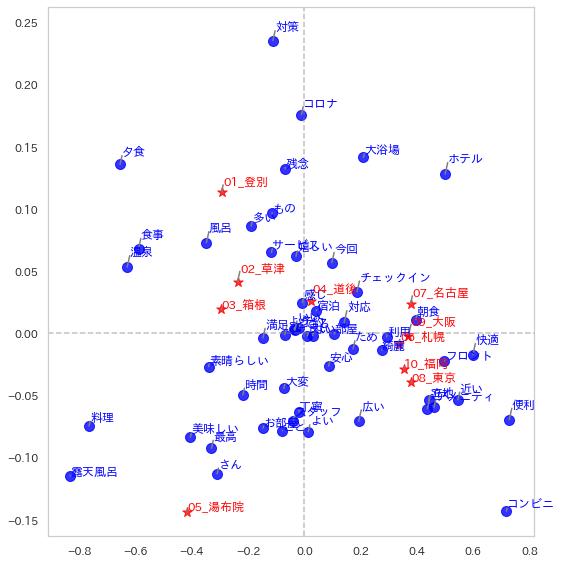

In [38]:
import random

plt.figure(figsize=(8,8))

# 列方向のプロット (単語)
plt.scatter(result_col[0], result_col[1], s=100, marker="o", c="blue", alpha=0.8)
for i in range(result_col.shape[0]):
    r = random.random() * 0.01
    plt.text(result_col.iloc[i, 0]+r, result_col.iloc[i, 1]+r, result_col.index[i], c="blue")
    plt.plot([result_col.iloc[i, 0]+r, result_col.iloc[i, 0]], [result_col.iloc[i, 1]+r, result_col.iloc[i, 1]], c="gray")

# 行方向のプロット (外部変数)
plt.scatter(result_row[0], result_row[1], s=100, marker="*", c="red", alpha=0.8)
for i in range(result_row.shape[0]):
    r = random.random() * 0.01
    plt.text(result_row.iloc[i, 0]+r, result_row.iloc[i, 1]+r, result_row.index[i], c="red")
    plt.plot([result_row.iloc[i, 0]+r, result_row.iloc[i, 0]], [result_row.iloc[i, 1]+r, result_row.iloc[i, 1]], c="gray")

plt.axhline(0, c="gray", ls='--', alpha=0.5)
plt.axvline(0, c="gray", ls='--', alpha=0.5)
plt.grid(False)
plt.tight_layout()

In [39]:
# 固有値
k = s ** 2
print(np.round(np.diag(k), decimals=4)) 

# 寄与率
print(np.round(100 * np.diag(k) / sum(s)))

[0.1048 0.0046 0.0041 0.0027 0.0019 0.0011 0.0009 0.0008 0.0006 0.    ]
[32.  7.  6.  5.  4.  3.  3.  3.  2.  0.]
